In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999

In [2]:
from subprocess import check_output
print(check_output(["ls", "../input/"]).decode("utf8"))

sample_submission.csv
test.csv
train.csv



##### Number of columns is more than the number of train rows. So need to be careful with feature selection / engineering
https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-santander-value

In [3]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Train rows and columns : ", train_df.shape)
print("Test rows and columns : ", test_df.shape)

Train rows and columns :  (4459, 4993)
Test rows and columns :  (49342, 4992)


In [4]:
train_df.head()

ID      target  48df886f9  0deb4b6a8  34b15f335  a8cb14b00  \
0  000d6aaf2  38000000.0        0.0          0        0.0          0   
1  000fbd867    600000.0        0.0          0        0.0          0   
2  0027d6b71  10000000.0        0.0          0        0.0          0   
3  0028cbf45   2000000.0        0.0          0        0.0          0   
4  002a68644  14400000.0        0.0          0        0.0          0   

   2f0771a37  30347e683  d08d1fbe3  6ee66e115  20aa07010  dc5a8f1d8  \
0          0          0          0          0        0.0        0.0   
1          0          0          0          0  2200000.0        0.0   
2          0          0          0          0        0.0        0.0   
3          0          0          0          0        0.0        0.0   
4          0          0          0          0  2000000.0        0.0   

   11d86fa6a  77c9823f2  8d6c2a0b2  4681de4fd  adf119b9a  cff75dd09  \
0        0.0          0          0          0          0        0.0   
1        0.0          0          0          0          0        0.0   
2        0.0          0          0          0          0        0.0   
3        0.0          0          0          0          0        0.0   
4        0.0          0          0          0          0        0.0   

   96f83a237  b8a716ebf  6c7a4567c  4fcfd2b4d  f3b9c0b95  71cebf11c  \
0          0        0.0          0          0        0.0          0   
1          0        0.0          0          0        0.0          0   
2          0        0.0          0          0        0.0          0   
3          0        0.0          0          0        0.0          0   
4          0        0.0          0          0        0.0          0   

   d966ac62c  68b647452  c88d108c9  ff7b471cd  d5308d8bc  0d866c3d7  \
0          0        0.0          0          0          0        0.0   
1          0        0.0          0          0          0        0.0   
2          0        0.0          0          0          0        0.0   
3          0        0.0          0          0          0        0.0   
4          0        0.0          0          0          0        0.0   

   bc3f77679  bd8f989f1  0eff5bf95  22ed6dba3  92b13ebba  c330f1a67  \
0          0        0.0          0        0.0        0.0          0   
1          0        0.0          0        0.0        0.0          0   
2          0        0.0          0        0.0        0.0          0   
3          0        0.0          0        0.0        0.0          0   
4          0        0.0          0        0.0        0.0          0   

   233c7c17c  2cb4d123e  eeac16933  87ffda550  822e49b95  316b978cd  \
0        0.0          0          0  1300000.0        0.0          0   
1        0.0          0          0        0.0        0.0          0   
2        0.0          0          0        0.0        0.0          0   
3        0.0          0          0        0.0        0.0          0   
4        0.0          0          0        0.0        0.0          0   

   d04e16aed  5d5c5ce6d  ec863cb52  11ad148bd  ea18d720e  408d86ce9  \
0        0.0          0          0        0.0        0.0        0.0   
1        0.0          0          0        0.0        0.0        0.0   
2        0.0          0          0        0.0        0.0        0.0   
3        0.0          0          0        0.0        0.0        0.0   
4        0.0          0          0        0.0        0.0        0.0   

   69d8b4020  b0868a049  80b14398e  ecdef52b2  c36bcacc5  151d318cd  \
0          0          0        0.0        0.0          0          0   
1          0          0        0.0        0.0          0          0   
2          0          0        0.0        0.0          0          0   
3          0          0        0.0        0.0          0          0   
4          0          0        0.0        0.0          0          0   

   ab0cddb90  2d6bd8275   dfdf4b580  c87722678  a8c320153  7df8788e8  \
0          0        0.0         0.0          0          0          0   
1          0     

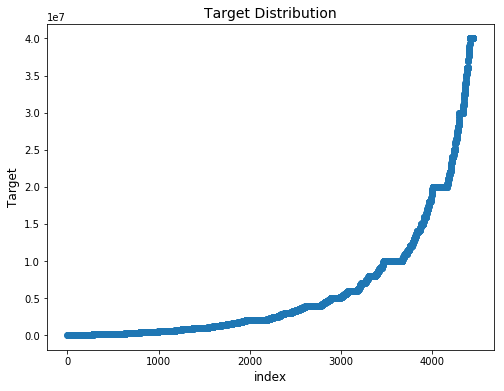

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

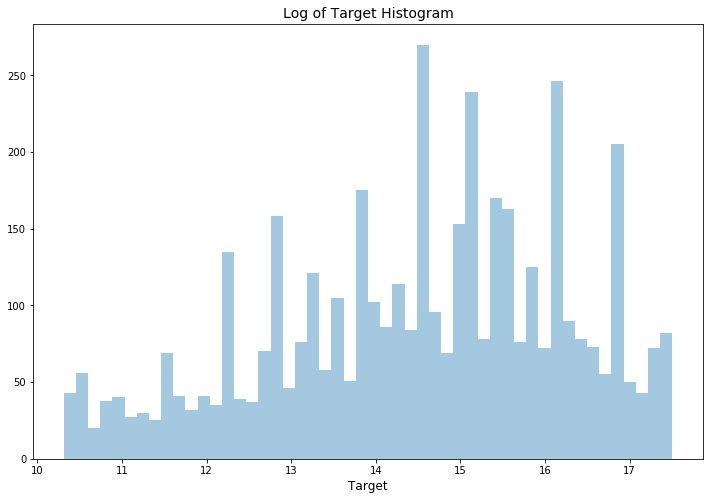

In [6]:
plt.figure(figsize=(12,8))
sns.distplot( np.log1p(train_df["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

In [7]:
# check missing values
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [8]:
train_df.head()

ID      target  48df886f9  0deb4b6a8  34b15f335  a8cb14b00  \
0  000d6aaf2  38000000.0        0.0          0        0.0          0   
1  000fbd867    600000.0        0.0          0        0.0          0   
2  0027d6b71  10000000.0        0.0          0        0.0          0   
3  0028cbf45   2000000.0        0.0          0        0.0          0   
4  002a68644  14400000.0        0.0          0        0.0          0   

   2f0771a37  30347e683  d08d1fbe3  6ee66e115  20aa07010  dc5a8f1d8  \
0          0          0          0          0        0.0        0.0   
1          0          0          0          0  2200000.0        0.0   
2          0          0          0          0        0.0        0.0   
3          0          0          0          0        0.0        0.0   
4          0          0          0          0  2000000.0        0.0   

   11d86fa6a  77c9823f2  8d6c2a0b2  4681de4fd  adf119b9a  cff75dd09  \
0        0.0          0          0          0          0        0.0   
1        0.0          0          0          0          0        0.0   
2        0.0          0          0          0          0        0.0   
3        0.0          0          0          0          0        0.0   
4        0.0          0          0          0          0        0.0   

   96f83a237  b8a716ebf  6c7a4567c  4fcfd2b4d  f3b9c0b95  71cebf11c  \
0          0        0.0          0          0        0.0          0   
1          0        0.0          0          0        0.0          0   
2          0        0.0          0          0        0.0          0   
3          0        0.0          0          0        0.0          0   
4          0        0.0          0          0        0.0          0   

   d966ac62c  68b647452  c88d108c9  ff7b471cd  d5308d8bc  0d866c3d7  \
0          0        0.0          0          0          0        0.0   
1          0        0.0          0          0          0        0.0   
2          0        0.0          0          0          0        0.0   
3          0        0.0          0          0          0        0.0   
4          0        0.0          0          0          0        0.0   

   bc3f77679  bd8f989f1  0eff5bf95  22ed6dba3  92b13ebba  c330f1a67  \
0          0        0.0          0        0.0        0.0          0   
1          0        0.0          0        0.0        0.0          0   
2          0        0.0          0        0.0        0.0          0   
3          0        0.0          0        0.0        0.0          0   
4          0        0.0          0        0.0        0.0          0   

   233c7c17c  2cb4d123e  eeac16933  87ffda550  822e49b95  316b978cd  \
0        0.0          0          0  1300000.0        0.0          0   
1        0.0          0          0        0.0        0.0          0   
2        0.0          0          0        0.0        0.0          0   
3        0.0          0          0        0.0        0.0          0   
4        0.0          0          0        0.0        0.0          0   

   d04e16aed  5d5c5ce6d  ec863cb52  11ad148bd  ea18d720e  408d86ce9  \
0        0.0          0          0        0.0        0.0        0.0   
1        0.0          0          0        0.0        0.0        0.0   
2        0.0          0          0        0.0        0.0        0.0   
3        0.0          0          0        0.0        0.0        0.0   
4        0.0          0          0        0.0        0.0        0.0   

   69d8b4020  b0868a049  80b14398e  ecdef52b2  c36bcacc5  151d318cd  \
0          0          0        0.0        0.0          0          0   
1          0          0        0.0        0.0          0          0   
2          0          0        0.0        0.0          0          0   
3          0          0        0.0        0.0          0          0   
4          0          0        0.0        0.0          0          0   

   ab0cddb90  2d6bd8275   dfdf4b580  c87722678  a8c320153  7df8788e8  \
0          0        0.0         0.0          0          0          0   
1          0     

In [9]:
# type of columns
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


In [10]:
unique_df = train_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

In [11]:
str(constant_df.col_name.tolist()[:5])

"['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee']"

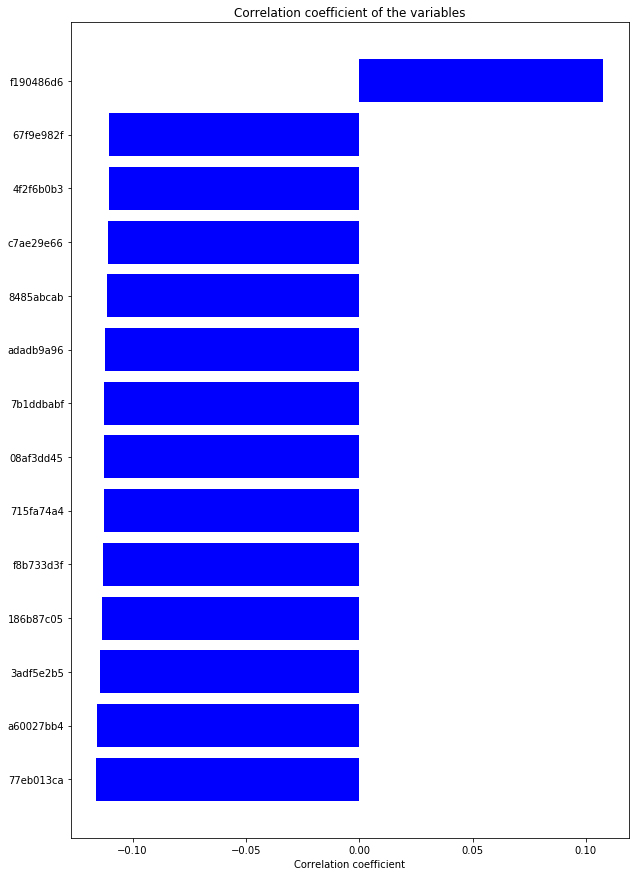

In [12]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

labels = []
values = []
for col in train_df.columns:
    if col not in ["ID", "target"]:
        labels.append(col)
        values.append(spearmanr(train_df[col].values, train_df["target"].values)[0])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.11)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,15))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

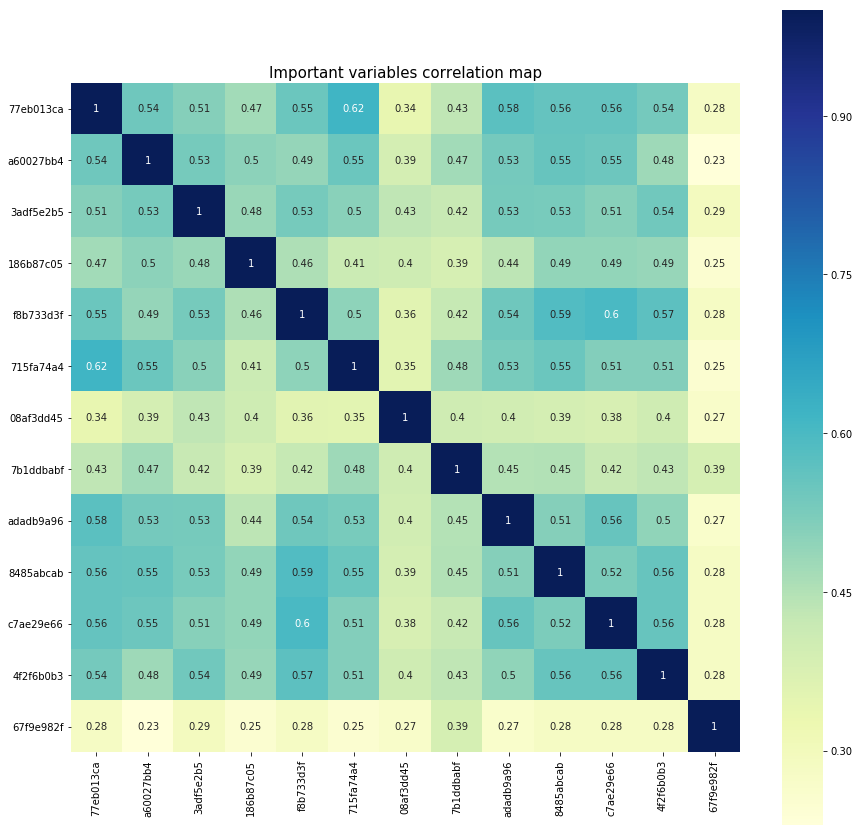

In [13]:
cols_to_use = corr_df[(corr_df['corr_values']>0.11) | (corr_df['corr_values']<-0.11)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(15, 15))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [14]:
### Get the X and y variables for building model ###
train_X = train_df.drop(constant_df.col_name.tolist() + ["ID", "target"], axis=1)
test_X = test_df.drop(constant_df.col_name.tolist() + ["ID"], axis=1)
train_y = np.log1p(train_df["target"].values)

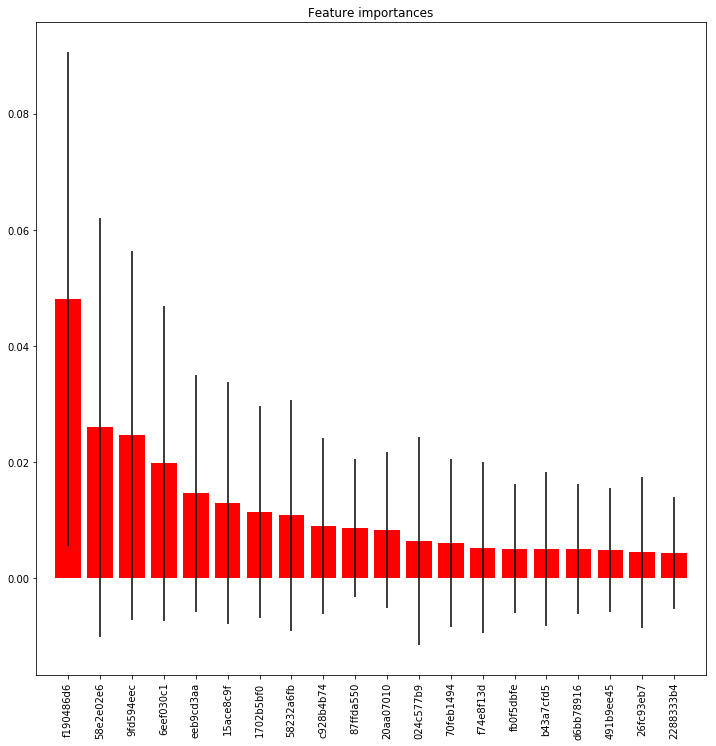

In [15]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [16]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [17]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44231
[400]	valid_0's rmse: 1.42178
Early stopping, best iteration is:
[380]	valid_0's rmse: 1.42093
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44249
[400]	valid_0's rmse: 1.40968
[600]	valid_0's rmse: 1.40662
Early stopping, best iteration is:
[532]	valid_0's rmse: 1.40543
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44369
[400]	valid_0's rmse: 1.41905
Early stopping, best iteration is:
[479]	valid_0's rmse: 1.41808
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.49096
[400]	valid_0's rmse: 1.45485
[600]	valid_0's rmse: 1.44857
[800]	valid_0's rmse: 1.44774
[1000]	valid_0's rmse: 1.44622
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 1.44611
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.48257
[400]	valid_0's rmse:

In [18]:
# Making a submission file #
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("../output/baseline_lgb.csv", index=False)

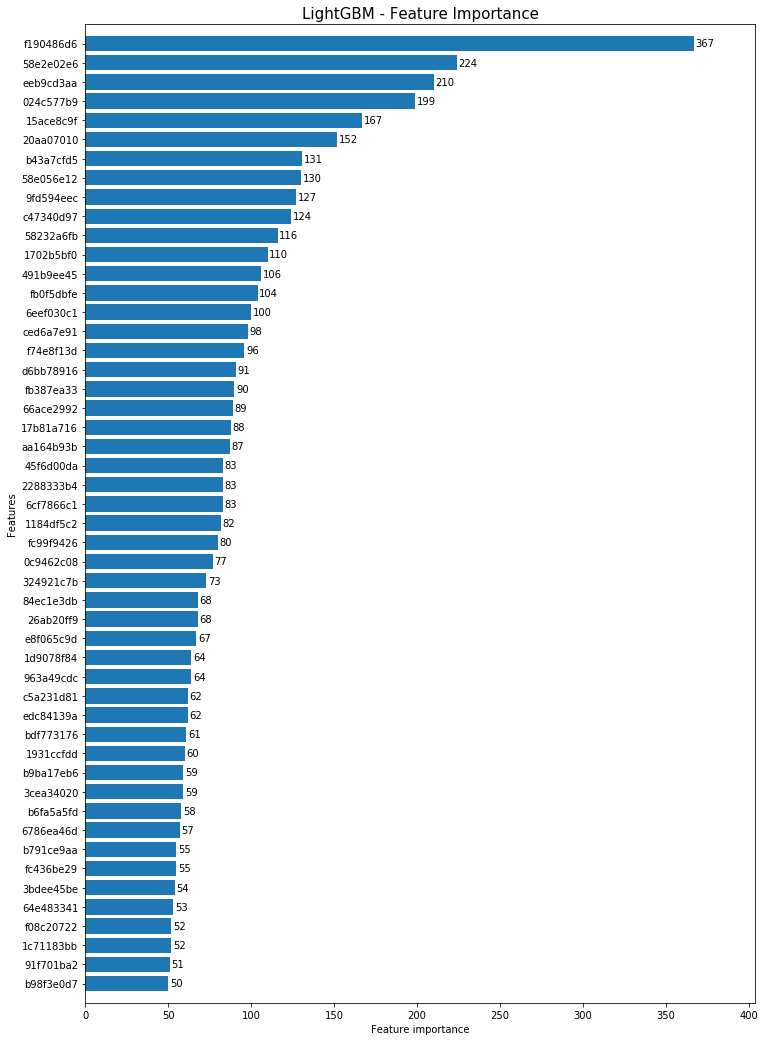

In [19]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()